# Assignment 2: Alfonsi, Di Tuccio and Orsini - Q&A with Transformers
In this assignment, we performed two question-and-answering tasks on the CoQA dataset with two Seq2Seq encoder-decoder models. In particular, the two models are initialized with a warm-starting encoder-decoder by using the pre-trained models Distil-RoBERTa and BERT-Tiny, and then fine-tuned for our specific tasks. In the end, the best model for both tasks was the one that uses Distil-RoBERTa, according to the SQUAD F1-score.<br><br>
This notebook is organized in chapters:
- chapter 1: import libraries, set random seed and download of the dataset;
- chapter 2: load the dataset;
- chapter 3: some statistics about the training data;
- chapter 4: dataset with the history + story;
- chapter 5: tokenizers;
- chapter 6: tokenize the dataset;
- chapter 7: train the models;
- chapter 8: test the models;
- chapter 9: Error Ananlysis. 

##1. Import libraries, set Random Seed and Download of the Dataset
Here we install and download the libraries that we will use in this notebook.

In [1]:
%%capture
!pip install allennlp-models
!pip install transformers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# imports
import os
import urllib.request
import json
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from numpy.random import seed
from datasets import Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.models import Model
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, EncoderDecoderModel, Seq2SeqTrainingArguments, Seq2SeqTrainer
from allennlp_models.rc.tools import squad
from transformers import AdamW, DataCollatorForSeq2Seq
import transformers
from tqdm import tqdm
import torch
import logging
import re


def set_global_logging_level(level=logging.ERROR, prefices=[""]):
    """
    Override logging levels of different modules based on their name as a prefix.
    It needs to be invoked after the modules have been loaded so that their loggers have been initialized.

    Args:
        - level: desired level. e.g. logging.INFO. Optional. Default is logging.ERROR
        - prefices: list of one or more str prefices to match (e.g. ["transformers", "torch"]). Optional.
          Default is `[""]` to match all active loggers.
          The match is a case-sensitive `module_name.startswith(prefix)`
    """
    prefix_re = re.compile(fr'^(?:{ "|".join(prefices) })')
    for name in logging.root.manager.loggerDict:
        if re.match(prefix_re, name):
            logging.getLogger(name).setLevel(level)
set_global_logging_level(logging.ERROR)


'''
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!! IMPORTANT - READ THIS !!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
reproducibility part:
in this notebook we've used the seed 42 for explaining the functions and the model;
at the end, you could see the results (and conclusions) with different seeds
'''
def set_reproducibility(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['PYTHONHASHSEED'] = str(seed)
    

random_seed = 42
set_reproducibility(random_seed)

Now, we download the dasatet (already splitted in train and test set) used for this task. Then we store the train and test set in a pandas; after that, we randomically split the train set in validation set (20% of the original train set) and train set (80% of the orginal training set):

In [3]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("\nDownload completed!")

# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')

coqa-train-v1.0.json: 49.0MB [00:08, 5.86MB/s]                            



Download completed!


coqa-dev-v1.0.json: 9.09MB [00:03, 2.96MB/s]                            


Download completed!


##2. Load the Dataset (including TASK-1, TASK-2)

Then, we load the json into a pandas DataFrame and we split the train into train and val (**TASK 2**).

In [4]:
def random_split(dataframe, size, seed):
  return train_test_split(dataframe, train_size=size, random_state=seed)

In [5]:
train_val = pd.DataFrame(json.load(open('coqa/train.json'))['data']).sort_values(by='id').reset_index().drop(columns='index')
df_test = pd.DataFrame(json.load(open('coqa/test.json'))['data']).sort_values(by='id').reset_index().drop(columns=['index', 'additional_answers'])
df_train, df_val = random_split(dataframe=train_val, size=.8, seed=seed)
print("Shape of the train set: ", df_train.shape)
print("Shape of the validation set:  ", df_val.shape)
print("Shape of the test set:  ", df_test.shape)
df_train.head()

Shape of the train set:  (5759, 7)
Shape of the validation set:   (1440, 7)
Shape of the test set:   (500, 7)


,source,id,filename,story,questions,answers,name
2034,race,3aajc4i4fgs19d9eomhhdun0259zjc,high4348.txt,"The bedroom door opened and a light went on, s...","[{'input_text': 'what signals end of nap?', 't...","[{'span_start': 4, 'span_end': 43, 'span_text'...",high4348.txt
4631,cnn,3of2m9aatgowkxfw67hte9ndhx8kz1,cnn_f5bad6fefeee26ec39ac6a1402d51d5e77855264.s...,United Nations (CNN) -- The U.N. Security Coun...,[{'input_text': 'Who is president of the UN se...,"[{'span_start': 243, 'span_end': 281, 'span_te...",cnn_f5bad6fefeee26ec39ac6a1402d51d5e77855264.s...
3973,wikipedia,3l2is5hsfaig646pxxa1p9p29danu2,Aviation.txt,Aviation is the practical aspect or art of aer...,[{'input_text': 'when did the modern age of av...,"[{'span_start': 812, 'span_end': 921, 'span_te...",Aviation.txt
1423,wikipedia,373erpl3yo8mlpjsqz18tx8arwsrt3,Oliver_Cromwell.txt,Oliver Cromwell (25 April 15993 September 1658...,"[{'input_text': 'who is this article about?', ...","[{'span_start': 0, 'span_end': 173, 'span_text...",Oliver_Cromwell.txt
122,gutenberg,30lb5cdzncau778s2e7bvp84368z0u,data/gutenberg/txt/Thornton Waldo Burgess___Th...,CHAPTER III \n\nLIGHTFOOT TELLS HOW HIS ANTLER...,[{'input_text': 'What had been hanging from Li...,"[{'span_start': 936, 'span_end': 999, 'span_te...",data/gutenberg/txt/Thornton Waldo Burgess___Th...


Here, each row corresponds to a dialogue with a source, name, id, filename, story and its questions and answers.<br><br>
Now, let's see the story, questions and answers of the first row:



In [6]:
df_train.iloc[0].story

'The bedroom door opened and a light went on, signaling an end to nap time.The toddle , sleepy-eyed, clambered to a swinging stand in his crib.He smiled, reached out to his father, and uttered what is fast becoming the cry of his generation: "iPhone!" Just as adults have a hard time putting down their iPhones, so the device is now the Toy of Choice for many 1-, 2- and 3-year-olds.The phenomenon is attracting the attention and concern of some childhood development specialists. Natasha Sykes, a mother of two in Atlanta, remembers the first time her daughter, Kelsey, now 3 but then barely 2 years old, held her husband\'s iPhone."She pressed the button and it lit up.I just remember her eyes.It was like \'Whoa!\' "The parents were charmed by their daughter\'s fascination.But then, said Ms.Sykes (herself a Black Berry user), "She got serious about the phone." Kelsey would ask for it.Then she\'d cry for it."It was like she\'d always want the phone," Ms.Sykes said. Apple, the iPhone\'s designe

In [7]:
df_train.iloc[0].questions[:3]

[{'input_text': 'what signals end of nap?', 'turn_id': 1},
 {'input_text': 'who did he reach out for?', 'turn_id': 2},
 {'input_text': 'who are apps aiming for?', 'turn_id': 3}]

In [8]:
df_train.iloc[0].answers[:3]

[{'span_start': 4,
  'span_end': 43,
  'span_text': 'bedroom door opened and a light went on',
  'input_text': 'bedroom door opened and a light went on',
  'turn_id': 1},
 {'span_start': 168,
  'span_end': 178,
  'span_text': 'his father',
  'input_text': 'his father',
  'turn_id': 2},
 {'span_start': 359,
  'span_end': 381,
  'span_text': '1-, 2- and 3-year-olds',
  'input_text': '1-, 2- and 3-year-olds',
  'turn_id': 3}]

Now, we try to build a new DataFrame where each question and answer are splitted (i.e. each row has the story, a single question and its answer). We've decided to do that for semplifying the tokenizer part. Also, we remove the unanswerable (**TASK 1**)

In [9]:
# build the dataframe as described before.
# unanswerable --> True if you want to remove the unanswerable answers
def build_dataframe(dataframe, unanswerable=True):
  tmp = []
  for i in range(dataframe.shape[0]):
    row = dataframe.iloc[i] # each row corresponds to a single dialogue
    story = row.story # get the story of the dialague
    for j in range(len(row.questions)):
      if row.answers[j]['input_text']=='unknown' and unanswerable: continue # remove unanswerable if the flag is activated

      # we use the append function because of time complexity: O(list append) < O(pd.concat)
      question = row.questions[j]['input_text'].lower()
      if "?" not in question: question=question+'?'
      tmp.append({'dialogue': i, 'source': row.source, 'story': story.lower(), "question": question, 'answer': row.answers[j]['input_text'].lower()})#, "span": row.answers[j]['span_text'], 'span_start':row.answers[j]['span_start'], 'span_end':row.answers[j]['span_end']})
  return pd.DataFrame(tmp)

In [10]:
train = build_dataframe(df_train)
val = build_dataframe(df_val)
test = build_dataframe(df_test)
print("Shape for train set: ", train.shape)
print("Shape for validation set: ", val.shape)
print("Shape for test set: ", test.shape)
train.head(12)

Shape for train set:  (85843, 5)
Shape for validation set:  (21433, 5)
Shape for test set:  (7917, 5)


,dialogue,source,story,question,answer
0,0,race,"the bedroom door opened and a light went on, s...",what signals end of nap?,bedroom door opened and a light went on
1,0,race,"the bedroom door opened and a light went on, s...",who did he reach out for?,his father
2,0,race,"the bedroom door opened and a light went on, s...",who are apps aiming for?,"1-, 2- and 3-year-olds"
3,0,race,"the bedroom door opened and a light went on, s...",who is natasha's daughter?,kelsey
4,0,race,"the bedroom door opened and a light went on, s...",how old?,three
5,0,race,"the bedroom door opened and a light went on, s...",what about then?,2 years old
6,0,race,"the bedroom door opened and a light went on, s...",what is the name of the doctor mentioned?,dr.gwenn schurgin o'keeffe
7,0,race,"the bedroom door opened and a light went on, s...",she's a member of?,the academy's council
8,0,race,"the bedroom door opened and a light went on, s...",is there a particular phone mentione?,iphones
9,1,cnn,united nations (cnn) -- the u.n. security coun...,who is president of the un security council?,nawaf salam


##3. Statistics on the Train
Fisrt, let's have a look to the statistics of the stories:

99 Percentile of story length is:  500


,story
count,85843.000000
mean,271.136622
std,61.853515
min,70.000000
25%,247.000000
50%,267.000000
75%,294.000000
max,1030.000000


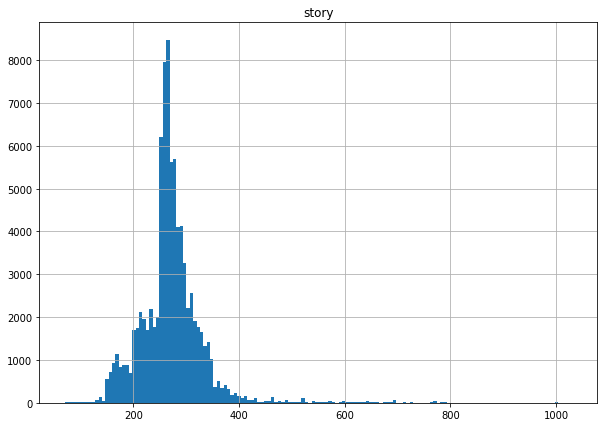

In [11]:
stat = pd.DataFrame(train.story.apply(lambda x: x.split(" ")).apply(len))
stat.hist(grid=True, bins=150, figsize=(10,7))
print('99 Percentile of story length is: ', int(stat.quantile(0.99)))
stat.describe()

As we can see, the max length of the story in the training set is 1030, while the 99 percentile is equal to 500.<br><br>
Now let's see the statistics for questions part:

Question max_length:  12


,question
count,85843.000000
mean,5.449495
std,2.473451
min,1.000000
25%,4.000000
50%,5.000000
75%,7.000000
max,45.000000


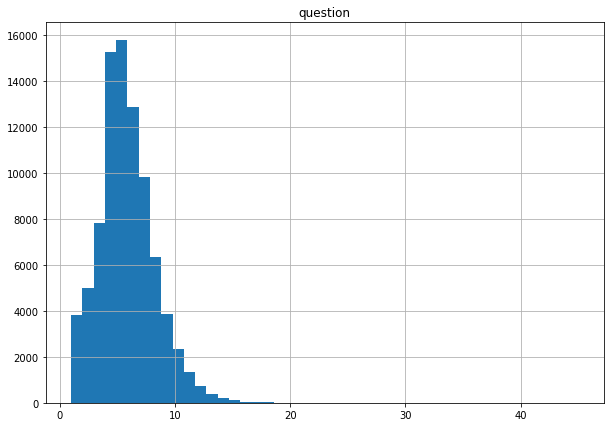

In [12]:
stat = pd.DataFrame(train.question.apply(lambda x: x.split(" ")).apply(len))
stat.hist(grid=True, bins=int(stat.max()), figsize=(10,7))
question_max_length = int(stat.quantile(0.99))
print('Question max_length: ', question_max_length)
stat.describe()

Regarding the questions of the training set, we can see that the max length is 45, while the 99 percentile is 12.<br>
Since the 99 percentile of the story is 500 and the 99 percentile of questions is 12, the sum of these two is 512, which is exactly the max input length of the encoder for BERT. For this reason, we choose 512 as input length for our models, since it avoids to truncate lot of examples.



In [13]:
encoder_max_length = 512

Then, the answer's statistics:

Answer max_length:  13


,answer
count,85843.000000
mean,2.674720
std,2.971248
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,353.000000


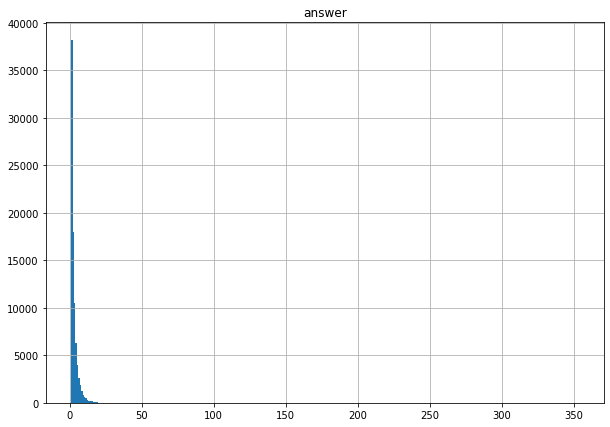

In [14]:
stat = pd.DataFrame(train.answer.apply(lambda x: x.split(" ")).apply(len))
stat.hist(grid=True, bins=int(stat.max()), figsize=(10,7))
answer_max_length = int(stat.quantile(0.99))
decoder_max_length = answer_max_length
print('Answer max_length: ', answer_max_length)
stat.describe()

Here, the max length is 353, while the 99 percentile is 13. So, we pick 13 as max length for the decoder.

##4. DataFrame with History (including the History Task) and its statistics on the Train
Before going in to details with the tokenizer part for transformers, we create another DataFrame for the history task (we recall that at Qi the history will be H=(Q0, A0, ..., Qi-1, Ai-1)).<br>
At each iteration, we create the history+story part composed by the history (with the questions and answers of the previous dialogue rows) plus the story, since the input of the encoder is actual question + history + story, in this order. Indeed, we keep the story as the last element since it will be the part eventually truncated, without loosing the history and the actual question.<br><br>
Now, let's see the function for creating the DataFrame with the history:

In [15]:
def dialogue_preprocess(df, encoder_max_length, decoder_max_length, question_max_length):
  row = []

  # for each unique dialogue
  for d in df['dialogue'].unique():
    df_tmp = df[df.dialogue == d] # store the rows of the same dialogue
    story = df_tmp['story'].iloc[0] # store the story
    source = df_tmp['source'].iloc[0] # store the source
    seq_quest_ans = [] # list used for storing questions + answers
   
    for j in range(df_tmp.shape[0]):
      
      # if an answer exceeds the decoder_max_length
      answer = df_tmp["answer"].iloc[j]
      if len(answer.split(" "))>decoder_max_length: answer=' '.join(answer.split(" ")[:decoder_max_length])
      
      # if an answer exceeds the decoder_max_length
      question = df_tmp["question"].iloc[j]
      if len(question.split(" "))>question_max_length: question=' '.join(question.split(" ")[:question_max_length-1])+'?' # restore the ? mark if the question is truncated
      
      # we separate the questions/answers and story with the dot char.
      # also we use the dot char for separating Q0-A0 with Q1-A1 and Q2-A2 and so on
      if not seq_quest_ans: row.append({'dialogue':d, 'source':source, 'history+story': story, 'question':question, 'answer':answer})
      else: row.append({'dialogue':d, 'source':source, 'history+story': '. '.join(seq_quest_ans) + '. ' + story, 'question':question, 'answer':answer})
      seq_quest_ans.append(question + ' ' + answer)
  return row

In [16]:
row = []
for i in tqdm(range(0,train.shape[0],500), desc = 'Progression:'):
  row = row + dialogue_preprocess(train.iloc[i:i+500], encoder_max_length, decoder_max_length, question_max_length)
train_history = pd.DataFrame(row)

Progression:: 100%|██████████| 172/172 [00:04<00:00, 35.78it/s]


In [17]:
train_history.head(12)

,dialogue,source,history+story,question,answer
0,0,race,"the bedroom door opened and a light went on, s...",what signals end of nap?,bedroom door opened and a light went on
1,0,race,what signals end of nap? bedroom door opened a...,who did he reach out for?,his father
2,0,race,what signals end of nap? bedroom door opened a...,who are apps aiming for?,"1-, 2- and 3-year-olds"
3,0,race,what signals end of nap? bedroom door opened a...,who is natasha's daughter?,kelsey
4,0,race,what signals end of nap? bedroom door opened a...,how old?,three
5,0,race,what signals end of nap? bedroom door opened a...,what about then?,2 years old
6,0,race,what signals end of nap? bedroom door opened a...,what is the name of the doctor mentioned?,dr.gwenn schurgin o'keeffe
7,0,race,what signals end of nap? bedroom door opened a...,she's a member of?,the academy's council
8,0,race,what signals end of nap? bedroom door opened a...,is there a particular phone mentione?,iphones
9,1,cnn,united nations (cnn) -- the u.n. security coun...,who is president of the un security council?,nawaf salam


In [18]:
train_history['history+story'].iloc[2]
# as we can see below, the third row of the dataset contains the questions and answers of the first two rows. 

'what signals end of nap? bedroom door opened and a light went on. who did he reach out for? his father. the bedroom door opened and a light went on, signaling an end to nap time.the toddle , sleepy-eyed, clambered to a swinging stand in his crib.he smiled, reached out to his father, and uttered what is fast becoming the cry of his generation: "iphone!" just as adults have a hard time putting down their iphones, so the device is now the toy of choice for many 1-, 2- and 3-year-olds.the phenomenon is attracting the attention and concern of some childhood development specialists. natasha sykes, a mother of two in atlanta, remembers the first time her daughter, kelsey, now 3 but then barely 2 years old, held her husband\'s iphone."she pressed the button and it lit up.i just remember her eyes.it was like \'whoa!\' "the parents were charmed by their daughter\'s fascination.but then, said ms.sykes (herself a black berry user), "she got serious about the phone." kelsey would ask for it.then s

Then, we evaluate some statistics for the history:

The 98 percentile of the history+story length is:  history+story    503.0
Name: 0.98, dtype: float64


,history+story
count,85843.000000
mean,331.805995
std,76.464280
min,70.000000
25%,284.000000
50%,326.000000
75%,372.000000
max,1166.000000


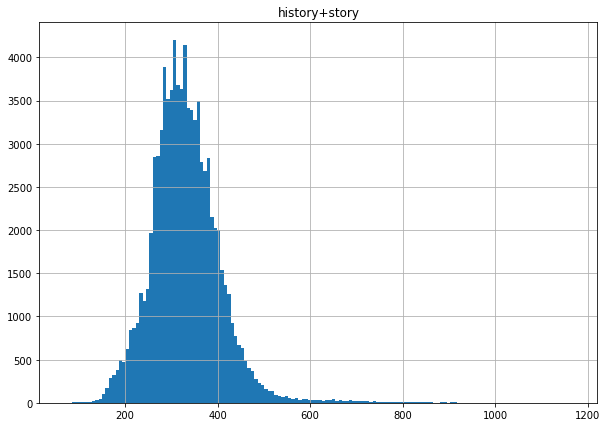

In [19]:
stat = pd.DataFrame(train_history['history+story'].apply(lambda x: x.split(" ")).apply(len))
stat.hist(grid=True, bins=150, figsize=(10,7))
print('The 98 percentile of the history+story length is: ', stat.quantile(0.98))
stat.describe()

Here, we can notice that the max length is 1166, which is 136 words longer than the max length of the story.<br>
Besides, the 98 percentile is 503 for history+story, while the max length of question is 12. In this case, our input can be 515 words long (i.e. 503 + 12 for questions), which is slightly higher than the encoder input length. Since there are only 3 words difference, we take 512 as our input max length.

In [20]:
# after that, we do the same for the validation split and test split
row = []
for i in tqdm(range(0,train.shape[0],500), desc = 'Progression:'):
  row = row + dialogue_preprocess(val.iloc[i:i+500], encoder_max_length, decoder_max_length, question_max_length)
val_history = pd.DataFrame(row)

row = []
for i in tqdm(range(0,train.shape[0],500), desc = 'Progression:'):
  row = row + dialogue_preprocess(test.iloc[i:i+500], encoder_max_length, decoder_max_length, question_max_length)
test_history = pd.DataFrame(row)

Progression:: 100%|██████████| 172/172 [00:00<00:00, 378.31it/s]


##5. Tokenizers
After loading the dialogues, we upload the tokenizers used in this assignment:
- distilroberta-base;
- prajjwal1/bert-tiny.

In [21]:
def load_tokenizer(name):
  tokenizer = AutoTokenizer.from_pretrained(name)
  
  # we use CLS also for BOS, and SEP for EOS
  tokenizer.bos_token = tokenizer.cls_token
  tokenizer.eos_token = tokenizer.sep_token
  print('Tokenizer: {0}, Special Token used: {1}, {2}'.format(name, tokenizer.bos_token, tokenizer.eos_token))
  return tokenizer

In [22]:
tokenizer_distilroberta = load_tokenizer("distilroberta-base")
tokenizer_berttiny = load_tokenizer("prajjwal1/bert-tiny")
tokenizers = [tokenizer_distilroberta, tokenizer_berttiny]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Tokenizer: distilroberta-base, Special Token used: <s>, </s>


Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Tokenizer: prajjwal1/bert-tiny, Special Token used: [CLS], [SEP]


Then, we test the bert-tiny tokenizer with the train:

In [25]:
current_element = train.iloc[0]
print("Current dialogue:")
print(current_element)
print()
token = tokenizer_berttiny(current_element.question, current_element.story, max_length=512, truncation="only_second")
print('Input_ids for BERT-Tiny tokenizer of the previous element: ', token['input_ids'])
print('Decode of the previous input_ids: ', tokenizer_berttiny.decode(token['input_ids']))

Current dialogue:
dialogue                                                    0
source                                                   race
story       the bedroom door opened and a light went on, s...
question                             what signals end of nap?
answer                bedroom door opened and a light went on
Name: 0, dtype: object

Input_ids for BERT-Tiny tokenizer of the previous element:  [101, 2054, 7755, 2203, 1997, 18996, 1029, 102, 1996, 5010, 2341, 2441, 1998, 1037, 2422, 2253, 2006, 1010, 14828, 2019, 2203, 2000, 18996, 2051, 1012, 1996, 6927, 2571, 1010, 17056, 1011, 7168, 1010, 18856, 3286, 22408, 2000, 1037, 11820, 3233, 1999, 2010, 13675, 12322, 1012, 2002, 3281, 1010, 2584, 2041, 2000, 2010, 2269, 1010, 1998, 20947, 2054, 2003, 3435, 3352, 1996, 5390, 1997, 2010, 4245, 1024, 1000, 18059, 999, 1000, 2074, 2004, 6001, 2031, 1037, 2524, 2051, 5128, 2091, 2037, 18059, 2015, 1010, 2061, 1996, 5080, 2003, 2085, 1996, 9121, 1997, 3601, 2005, 2116, 1015, 1011, 10

And we do the same for the history part: (the row 3 must contain the question+answer of the row 0, 1 and 2, and the story)

In [26]:
current_element = train_history.iloc[3]
print("Current element with history:")
print(current_element)
print()
token = tokenizer_berttiny(current_element.question, current_element['history+story'], max_length=512, truncation="only_second")
print('Input_ids for BERT-Tiny tokenizer of the previous element with history: ', token['input_ids'])
print('Decode of the previous input_ids: ', tokenizer_berttiny.decode(token['input_ids']))

Current element with history:
dialogue                                                         0
source                                                        race
history+story    what signals end of nap? bedroom door opened a...
question                                who is natasha's daughter?
answer                                                      kelsey
Name: 3, dtype: object

Input_ids for BERT-Tiny tokenizer of the previous element with history:  [101, 2040, 2003, 17399, 1005, 1055, 2684, 1029, 102, 2054, 7755, 2203, 1997, 18996, 1029, 5010, 2341, 2441, 1998, 1037, 2422, 2253, 2006, 1012, 2040, 2106, 2002, 3362, 2041, 2005, 1029, 2010, 2269, 1012, 2040, 2024, 18726, 13659, 2005, 1029, 1015, 1011, 1010, 1016, 1011, 1998, 1017, 1011, 2095, 1011, 19457, 1012, 1996, 5010, 2341, 2441, 1998, 1037, 2422, 2253, 2006, 1010, 14828, 2019, 2203, 2000, 18996, 2051, 1012, 1996, 6927, 2571, 1010, 17056, 1011, 7168, 1010, 18856, 3286, 22408, 2000, 1037, 11820, 3233, 1999, 2010, 13675, 12322

##6. Tokenizer on Dataset (including TASK-5 and TASK-6)
Here, we tokenize the Dataset using the previous tokenizers. We also append each result of the tokenizers to a dictionary.

In [27]:
def process_data_to_model_inputs(batch, tokenizer, history=False):

  # if the batch has the history+story, we use as input actual question + history + story
  if history:
    inputs = tokenizer(batch['question'], batch['history+story'], padding="max_length", truncation="only_second", max_length=encoder_max_length)
  
  # if the batch has only the story, we use as input actual question + story
  else:
    inputs = tokenizer(batch['question'], batch['story'], padding="max_length", truncation="only_second", max_length=encoder_max_length)
  
  # the output is simply the answer
  outputs = tokenizer(batch["answer"], padding="max_length", truncation=True, max_length=decoder_max_length)

  batch["input_ids"] = inputs.input_ids.copy() # we assign question(+history)+story to the input of the ENCODER
  batch["attention_mask"] = inputs.attention_mask.copy()  # we use the attention mask of question(+history)+story for the ENCODER
  batch["decoder_input_ids"] = outputs.input_ids.copy() # we assign the answers to the input of the DECODER
  batch["decoder_attention_mask"] = outputs.attention_mask.copy() # we use the attention mask of the answers for the DECODER
  batch["labels"] = outputs.input_ids.copy() # we use the answers as labels in the DECODER part

  # because BERT automatically shifts the labels, the labels correspond exactly to `decoder_input_ids`. 
  # We have to make sure that the PAD token is ignored
  batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]
  return inputs

In [28]:
batch_size=16 # the batch size value is choosen according to our computational limitation 

The following dictionary is used for testing the models with different seeds. The dictionary contains 4 keys, corresponding to the models (DistilRoBERTa with and without history and BERT-Tiny with and without history). Each key has the corresponding tokenizer and its train, val and test dataset.

In [37]:
'''
{
    'distil_roberta':
        {'tokenizer':tokenizer_distilroberta, 'train':train_dataset, 'val':val_dataset, 'test':test_dataset}, 
    'distil_roberta_history':
        {'tokenizer':tokenizer_distilroberta, 'train':train_dataset, 'val':val_dataset, 'test':test_dataset},
    'bert_tiny':
        {'tokenizer':tokenizer_berttiny, 'train':train_dataset, 'val':val_dataset, 'test':test_dataset},
    'bert_tiny_history':
        {'tokenizer':tokenizer_berttiny, 'train':train_dataset, 'val':val_dataset, 'test':test_dataset}
 }
'''

dict_of_tokenizers = {}
dict_of_tokenizers['distil_roberta']={'tokenizer':tokenizer_distilroberta, 'train':train, 'val':val, 'test':test, 'history':False, 'model':"distilroberta-base"}
dict_of_tokenizers['distil_roberta_history']={'tokenizer':tokenizer_distilroberta, 'train':train_history, 'val':val_history, 'test':test_history, 'history':True, 'model':"distilroberta-base"}
dict_of_tokenizers['bert_tiny']={'tokenizer':tokenizer_berttiny, 'train':train, 'val':val, 'test':test, 'history':False, 'model':"prajjwal1/bert-tiny"}
dict_of_tokenizers['bert_tiny_history']={'tokenizer':tokenizer_berttiny, 'train':train_history, 'val':val_history, 'test':test_history, 'history':True, 'model':"prajjwal1/bert-tiny"}

for key in list(dict_of_tokenizers.keys()):
  print('Preprocess: ', key)

  # convert pandas dataframe to huggingface dataset. We load only 10 elements for train and val -->
  # indeed, we load the weights of the models and we test it with the entire test set
  train_dataset = Dataset.from_pandas(dict_of_tokenizers[key]['train']).select(range(10))
  val_dataset = Dataset.from_pandas(dict_of_tokenizers[key]['val']).select(range(10))
  test_dataset = Dataset.from_pandas(dict_of_tokenizers[key]['test'])

  # map the train dataset for building inputs-outpus for the models
  train_dataset = train_dataset.map(lambda x: process_data_to_model_inputs(x, dict_of_tokenizers[key]['tokenizer'], history=dict_of_tokenizers[key]['history']), batched=True, batch_size=batch_size)

  # we convert the results into torch 
  train_dataset.set_format(type="torch", columns=list(train_dataset.features))

  # and we do the same for the val split
  val_dataset = val_dataset.map(lambda x: process_data_to_model_inputs(x, dict_of_tokenizers[key]['tokenizer'], history=dict_of_tokenizers[key]['history']), batched=True, batch_size=batch_size)
  val_dataset.set_format(type="torch", columns=list(val_dataset.features))
  
  # we saved the results into the dictionary
  dict_of_tokenizers[key]={'tokenizer':dict_of_tokenizers[key]['tokenizer'], 'train':train_dataset, 'val':val_dataset, 'test':test_dataset, 'history':dict_of_tokenizers[key]['history'], 'model':dict_of_tokenizers[key]['model']}

Preprocess:  distil_roberta


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Preprocess:  distil_roberta_history


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Preprocess:  bert_tiny


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Preprocess:  bert_tiny_history


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

##7. Train the Models (including TASK-4)
The hyperparameters were choosen according to the SQUAD F1 on the validation set.<br>
The hyperparameters are:
- decoder max length = 13 (according to the statistics);
- min length for encoder = 1;
- no repeat ngram size = 1;
- repetition penalty = 3;
- n. beams = 8;
- num_train_epochs = 3;
- weight_decay = 0.01;
- logging_steps = 10;
- eval_steps = 10;
- batch size = 16 (due to computational issue);
- optimizers: Adam with lr = 3e-5, n. warm up = 50, n. training steps = batch size * epochs;

<br>
TinyBERT --> 14.5M parameters<br>
DistilRoBERTa --> 82M parameters 

<br>


In [ ]:
# here, we define the SQUAD F1 metric used on the validation set
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    
    # all unnecessary tokens are removed
    pred_str = tokenizer_distilroberta.batch_decode(pred_ids, skip_special_tokens=True)
    
    labels_ids[labels_ids == -100] = tokenizer_distilroberta.pad_token_id
    
    label_str = tokenizer_distilroberta.batch_decode(labels_ids, skip_special_tokens=True)
    
    squads=[]
    for i in range(len(pred_str)):
      squads.append(squad.compute_f1(str(pred_str[i]), str(label_str[i])))
    mean_sqf1 = sum(squads)/len(squads)

    return {"squad_f1_score": round(mean_sqf1, 4)}

In [ ]:
'''

# since a for loop isn't computationally sustainable for these models, 
# we ran this notebook multiple time with different model and seed.

model_name = "distilroberta-base" --> used for distil roberta
model_name = 'prajjwal1/bert-tiny' --> used for bert-tiny
model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_name, model_name, tie_encoder_decoder=False)

# set special tokens using the previous tokenizer (i.e. tokenizer_berttiny or tokenizer_distilroberta)
model.config.decoder_start_token_id = tokenizer.bos_token_id 
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.encoder.vocab_size # we use the same vocabulary for both encoder-decoder 

# hyperparameters described above
model.config.max_length = decoder_max_length
model.config.min_length = 1
model.config.no_repeat_ngram_size = 1
model.config.early_stopping = True
model.config.repetition_penalty=3.
model.config.num_beams = 8

model.to("cuda")

os.environ["WANDB_DISABLED"] = "true"

# define the training arguments (eval_step, epochs, output for checkpoint, etc)
training_args = Seq2SeqTrainingArguments(
    output_dir='./drive/MyDrive/checkpoint',
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    overwrite_output_dir=True,
    save_total_limit=2,
    fp16=True, 
    num_train_epochs = 3,
    weight_decay=0.01,
    logging_steps=10,
    eval_steps=10,
    resume_from_checkpoint = True
)

# Adam and scheduler
optimizer=AdamW(model.parameters(),lr= 3e-5)
scheduler=transformers.get_cosine_schedule_with_warmup(optimizer=optimizer,num_warmup_steps=50,num_training_steps=batch_size*3)
optimizers=optimizer, scheduler

# initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dict_of_tokenizers['distil_roberta_history']['train'],
    eval_dataset=dict_of_tokenizers['distil_roberta_history']['val'],
    optimizers=optimizers,
    data_collator=DataCollatorForSeq2Seq(tokenizer,model=model)
)

trainer.train()


# save the previous model weights on Drive
os.makedirs("/content/drive/MyDrive/weigths")
distil_roberta2roberta.save_pretrained("/content/drive/MyDrive/weigths/model_name_folder_seed")

'''

##8. Test the models with different seeds
Here, we test the models using different seeds according to the istruction.

In [30]:
def compute_metrics_test(pred, label):
  squads=[]
  for i in range(len(pred)):
    squads.append(squad.compute_f1(str(pred[i]), str(label[i])))
  return squads

In [33]:
# it used for generate the prediction on the batch test set.
# it takes the tokenizer, the name of the model (key) and the batch input for the tokenizer (args, i.e. story or history+story)
def generate_summary(batch, args, tokenizer, key):

    # Tokenizer will automatically set [BOS] <text> [EOS]
    # cut off at BERT max length 512
    inputs =tokenizer(batch["question"], batch[args], padding="max_length", truncation='only_second', max_length=256, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")
    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    batch["pred"] = output_str
    batch['model'] = [key]*len(output_str)
    batch['SQUAD_F1'] = compute_metrics_test(batch["pred"], batch["answer"])
    return batch

In [38]:
from statistics import mean

weigths_path = '/content/drive/MyDrive/QuestionAnswering_EncoderDecoderTransformers/weights' # load the folder with the weights from the drive
folders = os.listdir(weigths_path) # all the folders inside weights are loaded


for key in list(dict_of_tokenizers.keys()): # for each model, we load the model from huggingface and our weights. Then, we test it with the test batch
  model_name = dict_of_tokenizers[key]['model']
  model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_name, model_name, tie_encoder_decoder=False)
  print('Model: ', key)
  results_squad = []
  for folder in folders:
    if key == '_'.join(folder.split('_')[:-1]): # load the weights using different seeds
      model = model.from_pretrained(weigths_path+'/'+folder) # load the weights using the current seed
      model.to("cuda")
      print('\tModel with seed {0} uploaded!'.format(folder.split('_')[-1]))

      # if a model takes the history+story part as input, we pass to the tokenizer the question and history+story
      if 'history' in key: results = dict_of_tokenizers[key]['test'].map(lambda x: generate_summary(x, 'history+story', dict_of_tokenizers[key]['tokenizer'], key), batched=True, batch_size=batch_size//2)
      else: results = dict_of_tokenizers[key]['test'].map(lambda x: generate_summary(x, 'story', dict_of_tokenizers[key]['tokenizer'], key), batched=True, batch_size=batch_size//2)
      pred_str = results["pred"]
      label_str = results["answer"]
      results_squad.append(compute_metrics_test(pred_str, label_str))
  results_squad = [mean(x) for x in results_squad]
  print('Mean F1 Squad: ', round(mean(results_squad),3))
  print()
  print()

Model:  distil_roberta
	Model with seed 2022 uploaded!


  0%|          | 0/990 [00:00<?, ?ba/s]

	Model with seed 1337 uploaded!


  0%|          | 0/990 [00:00<?, ?ba/s]

	Model with seed 42 uploaded!


  0%|          | 0/990 [00:00<?, ?ba/s]

Mean F1 Squad:  0.313


Model:  distil_roberta_history
	Model with seed 2022 uploaded!


  0%|          | 0/990 [00:00<?, ?ba/s]

	Model with seed 42 uploaded!


  0%|          | 0/990 [00:00<?, ?ba/s]

	Model with seed 1337 uploaded!


  0%|          | 0/990 [00:00<?, ?ba/s]

Mean F1 Squad:  0.289




Downloading:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

Model:  bert_tiny
	Model with seed 42 uploaded!


  0%|          | 0/990 [00:00<?, ?ba/s]

	Model with seed 2022 uploaded!


  0%|          | 0/990 [00:00<?, ?ba/s]

	Model with seed 1337 uploaded!


  0%|          | 0/990 [00:00<?, ?ba/s]

Mean F1 Squad:  0.086


Model:  bert_tiny_history
	Model with seed 42 uploaded!


  0%|          | 0/990 [00:00<?, ?ba/s]

	Model with seed 2022 uploaded!


  0%|          | 0/990 [00:00<?, ?ba/s]

	Model with seed 1337 uploaded!


  0%|          | 0/990 [00:00<?, ?ba/s]

Mean F1 Squad:  0.077




##9. Error Ananlysis (including TASK-7)
For an easy and fast error analysis, we save the previous results on two csv: 'history.csv' and 'story.csv'. The datasets are also saved in our GitHub repository.

In [2]:
!git clone https://github.com/DitucSpa/QuestionAnswering_EncoderDecoderTransformers

Cloning into 'QuestionAnswering_EncoderDecoderTransformers'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 14 (delta 5), reused 13 (delta 4), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [2]:
df_story = pd.read_csv('QuestionAnswering_EncoderDecoderTransformers/dataset/story.csv')
df_history = pd.read_csv('QuestionAnswering_EncoderDecoderTransformers/dataset/history.csv')
df_story.head(4)

,dialogue,source,story,question,answer,pred,model,SQUAD_F1
0,0,cnn,(cnn)sen. marco rubio said he'll make a decisi...,what's rubio going to decide in the next few w...,running for president,for running for president,distil_roberta,0.857143
1,0,cnn,(cnn)sen. marco rubio said he'll make a decisi...,does he feel confident about it?,yes,he's confident he will win the election,distil_roberta,0.000000
2,0,cnn,(cnn)sen. marco rubio said he'll make a decisi...,what policy is he not in favor of?,immigration,casa's cuba,distil_roberta,0.000000
3,0,cnn,(cnn)sen. marco rubio said he'll make a decisi...,what type of people does he think are dangerou...,radicalized individuals,baitainists,distil_roberta,0.000000


As we can see, the dataset also contains the SQUAD F1 between the prediction and the true answer.
<br>
<br>
Then, we show some statistics for each source.

In [3]:
dataset = df_story.copy()
for m in set(dataset.model):
    current_df = dataset[dataset.model==m]
    print('Model: ', m)
    for s in set(df_story.source):
        print('\tSource: {0}, SQUAD F1: {1}'.format(s, round(current_df[current_df.source==s].SQUAD_F1.sum()/current_df[current_df.source==s].shape[0],3)))
    print()
dataset = df_history.copy()
for m in set(dataset.model):
    current_df = dataset[dataset.model==m]
    print('Model: ', m)
    for s in set(df_story.source):
        print('\tSource: {0}, SQUAD F1: {1}'.format(s, round(current_df[current_df.source==s].SQUAD_F1.sum()/current_df[current_df.source==s].shape[0],3)))
    print()

Model:  distil_roberta
	Source: wikipedia, SQUAD F1: 0.356
	Source: gutenberg, SQUAD F1: 0.325
	Source: cnn, SQUAD F1: 0.337
	Source: mctest, SQUAD F1: 0.406
	Source: race, SQUAD F1: 0.344

Model:  bert_tiny
	Source: wikipedia, SQUAD F1: 0.089
	Source: gutenberg, SQUAD F1: 0.127
	Source: cnn, SQUAD F1: 0.072
	Source: mctest, SQUAD F1: 0.083
	Source: race, SQUAD F1: 0.1

Model:  bert_tiny_history
	Source: wikipedia, SQUAD F1: 0.077
	Source: gutenberg, SQUAD F1: 0.12
	Source: cnn, SQUAD F1: 0.062
	Source: mctest, SQUAD F1: 0.086
	Source: race, SQUAD F1: 0.098

Model:  distil_roberta_history
	Source: wikipedia, SQUAD F1: 0.278
	Source: gutenberg, SQUAD F1: 0.29
	Source: cnn, SQUAD F1: 0.288
	Source: mctest, SQUAD F1: 0.372
	Source: race, SQUAD F1: 0.291



###Distil RoBERTa
Here, we can see the 5 worst results for each source of the Distil RoBERTa model.

In [4]:
dataset = df_story[df_story.model=='distil_roberta']
error_results = pd.DataFrame(columns=df_story.columns)
for s in set(dataset.source):
    error_results = pd.concat([error_results, dataset[dataset.source==s].sort_values(by=['SQUAD_F1']).head(5)])
error_results.reset_index().drop(columns='index')

,dialogue,source,story,question,answer,pred,model,SQUAD_F1
0,230,wikipedia,france has the world's 6th largest economy by ...,is tourism popular in france?,yes,it's a major,distil_roberta,0.0
1,401,wikipedia,fifty-two countries have participated in the e...,what about australia?,yes,a debut.,distil_roberta,0.0
2,184,wikipedia,the arena football league (afl) is the highest...,how big is the field?,68-yards,about a full field,distil_roberta,0.0
3,184,wikipedia,the arena football league (afl) is the highest...,how it compares with nfl field?,about half the distance of an nfl field,it's a faster pace.,distil_roberta,0.0
4,184,wikipedia,the arena football league (afl) is the highest...,are there any other differences?,faster-paced,the united states,distil_roberta,0.0
5,494,gutenberg,chapter iii. \n\na raft. \n\nforester and marc...,on what?,a sofa,the steamboat,distil_roberta,0.0
6,257,gutenberg,chapter xxxiv \n\narthur remained at the gate ...,who did he tell that to?,to ruth,martin,distil_roberta,0.0
7,257,gutenberg,chapter xxxiv \n\narthur remained at the gate ...,why was she there?,to see whether he is coming for thanksgiving,she thought it would be dinner,distil_roberta,0.0
8,257,gutenberg,chapter xxxiv \n\narthur remained at the gate ...,did he answer her?,no,yes.,distil_roberta,0.0
9,257,gutenberg,chapter xxxiv \n\narthur remained at the gate ...,did she ask?,no,yes.,distil_roberta,0.0


It seems that the model struggle to generate answers for short questions that don't contain so much context or questions that need the previos context in a conversation (ex. where? who?). However, the model generate answers that make sense wrt the question, as we can see in the dialogue 276, for question 'what color?', the answer is in any case a color (it answers with blue instead of brown).<br>
<br>
Let's see the dialogue in details:

In [5]:
df_story[df_story.dialogue==276].iloc[0].story

"billy went to the farm to buy some beef for his brother's birthday. when he arrived there he saw that all six of the cows were sad and had brown spots. the cows were all eating their breakfast in a big grassy meadow. he thought that the spots looked very strange so he went closer to the cows to get a better look. when he got closer he also saw that there were five white chickens sitting on the fence. the fence was painted blue and had some dirty black spots on it. billy wondered where the dirty spots had come. soon he got close to the chickens and they got scared. all five chickens flew away and went to eat some food. after billy got a good look at the cows he went to the farmer to buy some beef. the farmer gave him four pounds of beef for ten dollars. billy thought that it was a good deal so he went home and cooked his brother dinner. his brother was very happy with the dinner. billy's mom was also very happy."

As we can see, the word 'blue' isn't in the dialogue and the model generates a wrong answer.
<br>
<br> Let's see how Distil RoBERTa works with history:

In [6]:
dataset = df_history[(df_history.model=='distil_roberta_history')&(df_history.dialogue==276)]
dataset.iloc[4:6][['dialogue', 'question', 'answer', 'pred', 'SQUAD_F1']]

,dialogue,question,answer,pred,SQUAD_F1
4424,276,did they have spots?,yes,brown spots.,0.000000
4425,276,what color?,brown,brown spots,0.666667


In this case, the history helps the model to generate the correct answer. However, the history model have a worse performance on the other examples. This may be explained by the few epochs used for the fine tuning.
<br>
<br>
Now, let's the best results for the model: it seems that, which longer questions and with context-question, the model performances better.

In [7]:
dataset = df_story[df_story.model=='distil_roberta']
error_results = pd.DataFrame(columns=df_story.columns)
for s in set(dataset.source):
    error_results = pd.concat([error_results, dataset[dataset.source==s].sort_values(by=['SQUAD_F1']).tail(5)])
error_results.reset_index().drop(columns='index')

,dialogue,source,story,question,answer,pred,model,SQUAD_F1
0,107,wikipedia,anthropology is the study of humans and their ...,do the us and europe agree on its categorization?,no,no.,distil_roberta,1.0
1,107,wikipedia,anthropology is the study of humans and their ...,who did virchow attack?,the evolutionists.,the evolutionists,distil_roberta,1.0
2,241,wikipedia,the federal city of bonn () is a city on the b...,is it involved in governing?,yes,yes.,distil_roberta,1.0
3,107,wikipedia,anthropology is the study of humans and their ...,in what year?,1869,1869,distil_roberta,1.0
4,93,wikipedia,argentina is subdivided into twenty-three prov...,who seceded from salta?,jujuy,jujuy,distil_roberta,1.0
5,295,gutenberg,"chapter xxii \n\nafter the runaways \n\n""why, ...",what type of person was found around the dynam...,the wild man,a wild man,distil_roberta,1.0
6,295,gutenberg,"chapter xxii \n\nafter the runaways \n\n""why, ...",was the wild man seen more than once?,yes,yes.,distil_roberta,1.0
7,302,gutenberg,chapter xv. a disobedient brother \n\ndan was ...,what did sara ray bring dan?,a pudding,a pudding.,distil_roberta,1.0
8,302,gutenberg,chapter xv. a disobedient brother \n\ndan was ...,can you name one of them?\,felix,felix,distil_roberta,1.0
9,263,gutenberg,chapter xv \n\nfor some time after the conclus...,did the wild dog approach?,yes.,yes.,distil_roberta,1.0


###Bert-Tiny

In [8]:
dataset = df_story[df_story.model=='bert_tiny']
error_results = pd.DataFrame(columns=df_story.columns)
for s in set(dataset.source):
    error_results = pd.concat([error_results, dataset[dataset.source==s].sort_values(by=['SQUAD_F1']).head(5)])
error_results.reset_index().drop(columns='index')

,dialogue,source,story,question,answer,pred,model,SQUAD_F1
0,4,wikipedia,wool is the textile fiber obtained from sheep ...,where are follicles located?,in the skin.,the atlantic ocean.,bert_tiny,0.0
1,297,wikipedia,a440 or a4 (also known as the stuttgart pitch)...,when did they reiterate their support for a4?,1975,the 19th century.,bert_tiny,0.0
2,297,wikipedia,a440 or a4 (also known as the stuttgart pitch)...,what happened in 1955?,it was used by the international organization ...,the world war ii.,bert_tiny,0.0
3,297,wikipedia,a440 or a4 (also known as the stuttgart pitch)...,what did they recommend?,that the a above middle c be tuned to 440 hz.,the world's.,bert_tiny,0.0
4,297,wikipedia,a440 or a4 (also known as the stuttgart pitch)...,who made a recommendation in 1936?,the american standards association,the united states.,bert_tiny,0.0
5,3,gutenberg,chapter xii \n\nthe meeting of the gee eyes \n...,what is the title of the chapter?,the meeting of the gee eyes,himself to see him.,bert_tiny,0.0
6,345,gutenberg,chapter viii \n\n\n\nfive minutes after paula ...,how long had paula been gone before he left too.?,five minutes,two years,bert_tiny,0.0
7,345,gutenberg,chapter viii \n\n\n\nfive minutes after paula ...,how many telegrams wwere disposed of?,four,two years,bert_tiny,0.0
8,343,gutenberg,chapter viii \n\nthe house in onslow crescent ...,did she break up with him?,yes,no.,bert_tiny,0.0
9,343,gutenberg,chapter viii \n\nthe house in onslow crescent ...,who had he loved earlier?,julia,her father,bert_tiny,0.0


In [13]:
dataset = df_story[df_story.model=='bert_tiny']
error_results = pd.DataFrame(columns=df_story.columns)
for s in set(dataset.source):
    error_results = pd.concat([error_results, dataset[dataset.source==s].sort_values(by=['SQUAD_F1']).tail(10)])
error_results.reset_index().drop(columns='index')

,dialogue,source,story,question,answer,pred,model,SQUAD_F1
0,280,wikipedia,guam (i/ˈɡwɑːm/ or /ˈɡwɒm/; chamorro: guåhån;[...,are they recently established there?,no,no.,bert_tiny,1.0
1,280,wikipedia,guam (i/ˈɡwɑːm/ or /ˈɡwɒm/; chamorro: guåhån;[...,is it the smallest of it's group of islands?,no,no.,bert_tiny,1.0
2,186,wikipedia,endemism is the ecological state of a species ...,was he studying animal species?,no.,no.,bert_tiny,1.0
3,280,wikipedia,guam (i/ˈɡwɑːm/ or /ˈɡwɒm/; chamorro: guåhån;[...,who is this place a part of?,united states.,the united states,bert_tiny,1.0
4,267,wikipedia,"yorkshire ( or ; abbreviated yorks), formally ...",is this a large country?,yes,. yes,bert_tiny,1.0
5,19,wikipedia,"the achaemenid empire, also called the first p...",is it known for emancipation?,yes,- yes,bert_tiny,1.0
6,159,wikipedia,schleswig-holstein is the northernmost of the ...,was holstein part of the holy roman empire?,yes,- yes,bert_tiny,1.0
7,420,wikipedia,the christian science monitor (csm) is an inte...,is the monitor a religious themed paper?,no,no.,bert_tiny,1.0
8,477,wikipedia,plymouth (i/ˈplɪməθ/) is a city on the south c...,"is plymouth in england, 38 miles south-west of...",no,no.,bert_tiny,1.0
9,230,wikipedia,france has the world's 6th largest economy by ...,is tourism popular in france?,yes,", yes",bert_tiny,1.0


The considerations made on the Distil RoBERTa can be extended also to BERT-Tiny. We can also noticed that the best answers generated by the model initialized with BERT-Tiny's weights are boolean yes-or-no, while the other model has the best performances also to questions that need to generate more complex answers; this can be explained by the fact that Distil-RoBERTa is a more powerful model than BERT-Tiny (which has much fewer parameters).

# GitHub Repository

You can find the PDF, the notebook and the datasets on: https://github.com/DitucSpa/QuestionAnswering_EncoderDecoderTransformers